In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup
from cryoS2Sdrop.dataloader import singleCET_dataset, singleCET_FourierDataset, singleCET_ProjectedDataset
from cryoS2Sdrop.model import Denoising_3DUNet, Denoising_3DUNet_v2
from cryoS2Sdrop.losses import self2selfLoss_noMask

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchinfo import summary

import os
from torch.utils.data import Dataset, DataLoader

PARENT_PATH = setup.PARENT_PATH

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
# cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 
# cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_dummy.mrc')
# gt_cet_path = None

simulated_model = 'model14'
cet_path = os.path.join(
    PARENT_PATH, "data/S2SDenoising/dummy_tomograms/tomoPhantom_%s_Poisson5000+Gauss5+stripes.mrc" %simulated_model
)
gt_cet_path = os.path.join(
    PARENT_PATH, "data/S2SDenoising/dummy_tomograms/tomoPhantom_%s.mrc" %simulated_model
)

subtomo_length = 96

my_dataset = singleCET_ProjectedDataset(cet_path, subtomo_length=subtomo_length, gt_tomo_path=gt_cet_path)

In [3]:
# def collate_fn(batch):
#     bernoulli_subtomo = torch.cat([b[0] for b in batch], axis=0)
#     target = torch.cat([b[1] for b in batch], axis=0)
    
#     try:
#         gt_subtomo = torch.cat([b[2] for b in batch], axis=0)
#     except TypeError:
#         gt_subtomo = None
    
#     return bernoulli_subtomo, target, gt_subtomo

# def collate_fn(batch):
#     "Default pytorch collate_fn does not handle None"
#     subtomo, target, mask, gt_subtomo = batch
#     return subtomo, target, mask, gt_subtomo

def collate_fn(batch):
    batch = [list(filter(lambda x: x is not None, b)) for b in batch]
    return torch.utils.data.dataloader.default_collate(batch)

In [4]:
batch_size = 10
dloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, collate_fn=collate_fn)

# Model

In [5]:
for batch in dloader:
    subtomo, target, gt_subtomo = batch
    print(subtomo.shape, target.shape)
    break

torch.Size([10, 1, 96, 96, 96]) torch.Size([10, 1, 96, 96, 96])


In [6]:
gt_subtomo is None

False

In [16]:
n_features = 48
p = 0.3
model = Denoising_3DUNet_v2(self2selfLoss_noMask, 0, n_features, p, n_bernoulli_samples=1)

In [8]:
model(subtomo).shape

torch.Size([10, 1, 96, 96, 96])

In [9]:
summary(model, (batch_size, 1, subtomo_length, subtomo_length, subtomo_length), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Denoising_3DUNet_v2                      [10, 1, 96, 96, 96]       --
├─PartialConv3d: 1-1                     [10, 48, 96, 96, 96]      1,344
├─Sequential: 1-2                        [10, 48, 48, 48, 48]      --
│    └─PartialConv3d: 2-1                [10, 48, 96, 96, 96]      62,256
│    └─LeakyReLU: 2-2                    [10, 48, 96, 96, 96]      --
│    └─MaxPool3d: 2-3                    [10, 48, 48, 48, 48]      --
├─Sequential: 1-3                        [10, 48, 24, 24, 24]      --
│    └─PartialConv3d: 2-4                [10, 48, 48, 48, 48]      62,256
│    └─LeakyReLU: 2-5                    [10, 48, 48, 48, 48]      --
│    └─MaxPool3d: 2-6                    [10, 48, 24, 24, 24]      --
├─Sequential: 1-4                        [10, 48, 12, 12, 12]      --
│    └─PartialConv3d: 2-7                [10, 48, 24, 24, 24]      62,256
│    └─LeakyReLU: 2-8                    [10, 48, 24, 24, 24]      --


# Loss function

In [10]:
pred = model(subtomo)
pred.shape

torch.Size([10, 1, 96, 96, 96])

In [11]:
from cryoS2Sdrop.losses import self2self_L2Loss, TotalVariation, self2selfLoss_noMask
# loss = self2self_L2Loss()
# TV = TotalVariation()
loss = self2selfLoss_noMask(alpha=0.005)

In [12]:
loss(pred, target)

tensor(6413469., grad_fn=<AddBackward0>)

# Monitor function: SSIM and PSNR

In [6]:
from pytorch_msssim import ssim
from torchmetrics.functional import peak_signal_noise_ratio, mean_squared_error

In [18]:
for batch in dloader:
    subtomo, target, gt_subtomo = batch
    pred = model(subtomo)
    print(subtomo.shape, target.shape)
    break
    
for i,j in zip(torch.split(pred, 1), torch.split(gt_subtomo, 1)):
    i, j
    print(i.shape)
    break

torch.Size([10, 1, 96, 96, 96]) torch.Size([10, 1, 96, 96, 96])
torch.Size([1, 1, 96, 96, 96])


In [8]:
len(torch.split(subtomo, 1))

10

In [9]:
data_range = 10
data_range

10

In [19]:
j.abs().max()

tensor(0.3015)

(array([     0.,      0.,      0.,      0.,      0., 884736.,      0.,
             0.,      0.,      0.]),
 array([-0.80153286, -0.70153284, -0.6015329 , -0.50153285, -0.40153286,
        -0.30153286, -0.20153287, -0.10153286, -0.00153286,  0.09846713,
         0.19846714], dtype=float32),
 <BarContainer object of 10 artists>)

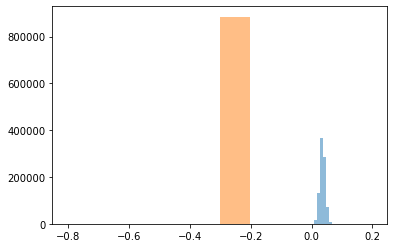

In [22]:
plt.hist(i.detach().numpy().flatten(), alpha=0.5)
plt.hist(j.numpy().flatten(), alpha=0.5)

In [23]:
float(ssim(i.mean((0)), j.mean((0)))), float(peak_signal_noise_ratio(i.mean((0)), j.mean((0)), data_range=data_range))

(0.9826852679252625, 29.426454544067383)

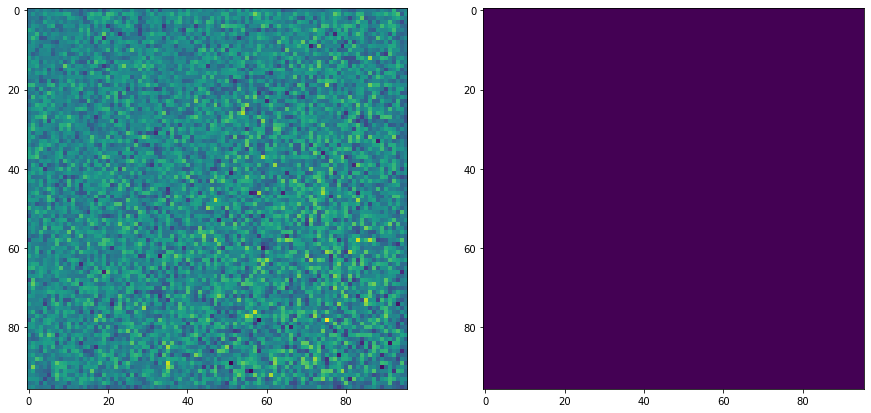

In [25]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 8))
zidx = 46
ax0.imshow(i.detach().mean((0, 1))[zidx])
ax1.imshow(j.mean((0, 1))[zidx])